In [1]:
# Load images.
from skimage.io import imread, imshow

waveChannel = imread('TIRF561-250-nM-arp-cp-5-uM-prof-actin.tif')
actinChannel= imread('TIRF488-250-nM-arp-cp-5-uM-prof-actin.tif')

In [2]:
# Make masks based on wave channel.
from numpy import array, zeros
from skimage.filters import threshold_otsu
from skimage.measure import label
stackSize = waveChannel.shape
labelWaveChannel = zeros(stackSize, dtype = 'int')
bwWaveChannel = zeros(stackSize, dtype = 'int')
noFrames = stackSize[0]

for i in range(noFrames):
    otsuThreshold = threshold_otsu(waveChannel[i])
    bwWaveChannel[i] = waveChannel[i] > otsuThreshold
    labelWaveChannel[i] = label(bwWaveChannel[i])

In [3]:
# Look up intensity values in the actin channel.
from skimage.measure import regionprops, label
from numpy import mean, append, empty, reshape
meanIntArr = array([])
xCentroidArr = array([])
yCentroidArr = array([])
iFrameArr = array([], dtype = 'int')

for i in range(noFrames):
    meanBackInt = mean(actinChannel[i][bwWaveChannel[i] == 0])
    properties = regionprops(labelWaveChannel[i], intensity_image = actinChannel[i] - meanBackInt)
    for region in properties:
        meanIntArr = append(meanIntArr, region.mean_intensity)
        xCentroidArr = append(xCentroidArr, region.centroid[0])
        yCentroidArr = append(yCentroidArr, region.centroid[1])
        iFrameArr = append(iFrameArr, i)

In [4]:
# Link objects.
from numpy import sqrt, amin
noObjects = sum(iFrameArr == 0)
meanIntMat = zeros((noObjects, noFrames))

for i in range(noObjects):
    meanIntMat[i, 0] = meanIntArr[i]
    
for i in range(noObjects):
    for j in range(1, noFrames):
        frameMeanIntArr = meanIntArr[iFrameArr == j]
        frameXCentroidArr = xCentroidArr[iFrameArr == j]
        frameYCentroidArr = yCentroidArr[iFrameArr == j]
        distanceArr = sqrt((frameXCentroidArr - xCentroidArr[i])**2 + (frameYCentroidArr - yCentroidArr[i])**2)
        meanIntMat[i, j] = frameMeanIntArr[distanceArr == amin(distanceArr)]

Text(0,0.5,'Mean intensity')

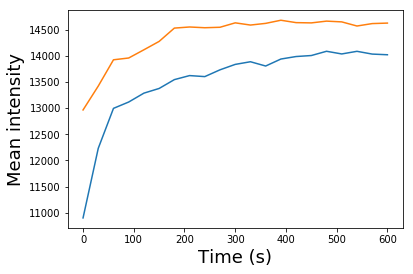

In [5]:
# Plot
from matplotlib.pyplot import plot, xlabel, ylabel
from numpy import arange
timeArr = arange(0.0, 30.0 * noFrames, 30.0)
%matplotlib inline

for i in range(noObjects):
    plot(timeArr, meanIntMat[i, :])
    
xlabel(r"Time (s)", fontsize = 18)
ylabel(r"Mean intensity", fontsize = 18)